# Attention

前回のseq2seqを改善するためにAttentionと呼ばれる手法を導入します。  
SimpleRNNにゲートを加えてLSTMが作られたように、情報の流し方をより適切に制御することを目指します。

## Attentionとは

まずは説明、理解が大事ですね。  

翻訳や音声認識など、ある時系列データを別の時系列データに変換するタスクでは、  
時系列データ間に対応関係が存在することが多くありますが、  
Attentionではこの2つの時系列データ間の対応関係をデータから学習しています。  

対応関係というのは「アライメント」とも表現されますが、  
例えば翻訳では、「猫=cat」のような翻訳先の単語と意味が対応していることを指します。  
つまり、Attentionは「入力と出力でどの単語が関連しているのか」を学習するのです。  

Attentionの働きとしては「単語のアライメント抽出」と言えます。

Attentionでは例えば、ベクトルの内積を使ってベクトル間の類似度を算出し、  
その類似度を用いた重み付き和ベクトルがAttentionの出力になります。  

Attentionで使用する演算は微分可能であるため、バックプロパゲーションによって学習ができます。  

Attentionが算出する重み(確率)を可視化することで、出入力の対応関係を見ることも出来ます。  

進んだ話ではRNNの替わりにより改良されたAttentionを使用し、モデルの精度をあげているようです。  
それは Self-Attention と呼ばれる技術になります。

## function

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## optimizer

In [0]:
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    Momentum SGD
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

## util

In [0]:
def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('evaluating perplexity ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    ###################### add here
    import numpy as np
    ######################
    
    correct = correct.flatten()
    # 頭の区切り文字
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 文字列へ変換
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s is not found' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

## layers

In [0]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

## time_layers

In [0]:


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

## BaseModel

In [0]:
import pickle

class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None): # not use here notebook
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]

## seq2seq

In [0]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

## peeky_seq2seq

In [0]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## dataset

In [0]:
import os
import numpy


id_to_char = {}
char_to_id = {}


def _update_vocab(txt):
    chars = list(txt)

    for i, char in enumerate(chars):
        if char not in char_to_id:
            tmp_id = len(char_to_id)
            char_to_id[char] = tmp_id
            id_to_char[tmp_id] = char


def load_data(file_name='date.txt', seed=1984):
    file_path = os.path.dirname(os.path.abspath('~/')) + '/' + file_name

    if not os.path.exists(file_path):
        print('No file: %s' % file_name)
        return None

    questions, answers = [], []

    for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx])
        answers.append(line[idx:-1])

    # create vocab dict
    for i in range(len(questions)):
        q, a = questions[i], answers[i]
        _update_vocab(q)
        _update_vocab(a)

    # create numpy array
    x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
    t = numpy.zeros((len(questions), len(answers[0])), dtype=numpy.int)

    for i, sentence in enumerate(questions):
        x[i] = [char_to_id[c] for c in list(sentence)]
    for i, sentence in enumerate(answers):
        t[i] = [char_to_id[c] for c in list(sentence)]

    # shuffle
    indices = numpy.arange(len(x))
    if seed is not None:
        numpy.random.seed(seed)
    numpy.random.shuffle(indices)
    x = x[indices]
    t = t[indices]

    # 10% for validation set
    split_at = len(x) - len(x) // 10
    (x_train, x_test) = x[:split_at], x[split_at:]
    (t_train, t_test) = t[:split_at], t[split_at:]

    return (x_train, t_train), (x_test, t_test)


def get_vocab():
    return char_to_id, id_to_char

## Trainer

In [0]:
# coding: utf-8
import numpy
import time
import matplotlib.pyplot as plt


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                #################### add here
                if GPU:
                    batch_x = to_gpu(batch_x)
                    batch_t = to_gpu(batch_t)
                ####################

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

## attention_layer

In [0]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da


class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh


class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## attention_seq2seq

In [0]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
#         ################### add here
#         sample_id = to_cpu(sample_id)
#         ###################
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## train

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 14[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 28[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 42[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 56[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 70[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 84[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 98[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 113[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 127[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 141[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 155[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 169[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 183[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 197[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 211[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 226[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 240[s] | loss 1.00
Q 10/15/94                     
T 1994-10-1

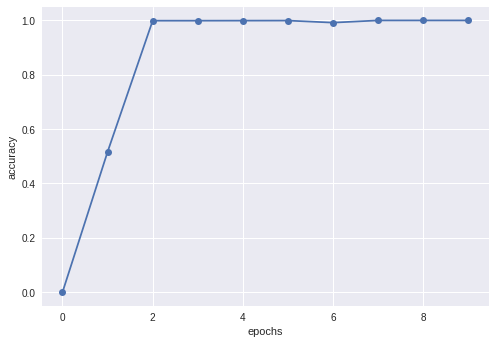

In [31]:
import numpy as np
GPU = False

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_data('date.txt')
char_to_id, id_to_char = get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

# グラフの描画
x = np.arange(len(acc_list))

################## add here
if GPU:
    x = to_cpu(x)
##################

plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

## visualize_attention

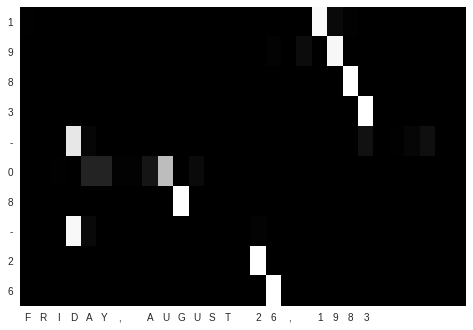

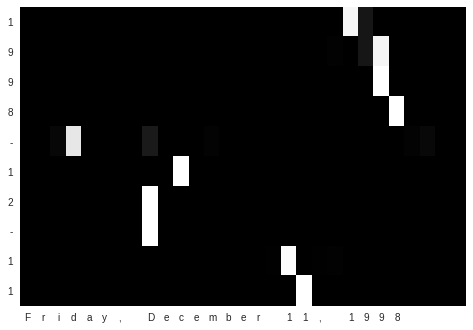

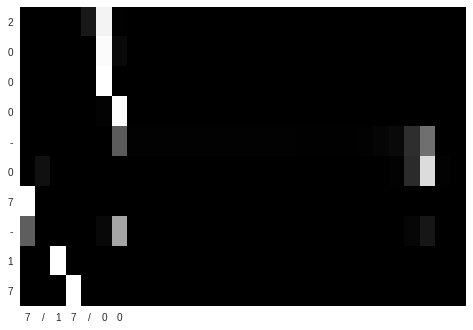

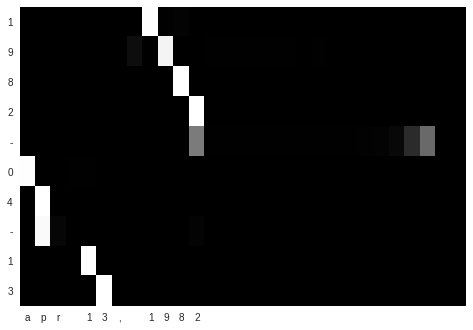

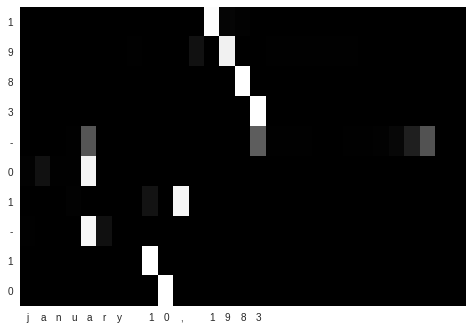

In [32]:
(x_train, t_train), (x_test, t_test) = load_data('date.txt')
char_to_id, id_to_char = get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

今回もcupyに挑戦してみていましたが、うまくいかず日が回りそうなのでひとまず諦めます  
まだまだコーディング力が足りないなと身をしみて感じました。  

観察としては、例えばepoch６のところで、  
accuracyが、出力される回答は全て正解でも、  
確率的には不完全だったのか99%を返しており、  
経験の精度、思考の精度を表しているところは深層学習だなぁと感じました。  

自然言語の分野で、RNNやAttentionのことを学ぶことをして素直によかったです。  
深層学習において様々な分野に応用されている技術なのだなということが理解でき、  
やる気なくしていた頃の自分には反省してもらおうと思います。